In [ ]:
! pip install transformers pytorch-lightning --quiet
! sudo apt -qq install git-lfs
! git config --global credential.helper store

     |████████████████████████████████| 4.2 MB 5.1 MB/s 
     |████████████████████████████████| 585 kB 76.8 MB/s 
     |████████████████████████████████| 86 kB 6.2 MB/s 
     |████████████████████████████████| 596 kB 78.7 MB/s 


In [ ]:
import os
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
import requests
import math
import matplotlib.pyplot as plt
import shutil
from getpass import getpass
from PIL import Image, UnidentifiedImageError
from requests.exceptions import HTTPError
from io import BytesIO
from pathlib import Path
import torch
import pytorch_lightning as pl
from huggingface_hub import HfApi, HfFolder, Repository, notebook_login
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from transformers import ViTFeatureExtractor, ViTForImageClassification
#from transformers import AutoFeatureExtractor, SwinForImageClassification
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from torchvision import transforms

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
drive_dir = '/content/drive/MyDrive/GP DataSet/DataSets/C-NMC_Leukemia/training_data/'

In [ ]:
folders = ['fold_0','fold_1','fold_2']
labels = ['hem','all']
img_size = 250
def get_data(data_dir):
    data = [] 
    for folder in folders :
      fold = os.path.join(data_dir, folder)
      for label in labels: 
          path = os.path.join(fold, label)
          class_num = labels.index(label)
          for img in os.listdir(path):
              try:
                  img_arr = cv2.imread(os.path.join(path, img))[...,::-1]
                  resized_arr = cv2.resize(img_arr, (img_size, img_size))
                  if(label=="hem"):
                    da1=cv2.rotate(resized_arr,cv2.ROTATE_90_COUNTERCLOCKWISE)
                    data.append([da1, class_num])
                  data.append([resized_arr, class_num])
              except Exception as e:
                  print(e)
    return np.array(data)

In [ ]:
train_data = get_data(drive_dir)
np.random.shuffle(train_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
def show_data(ty):
  l = []
  all_ind = []
  hem_ind = []
  ind_t = 0
  for i in ty:
      if(i[1] == 0):
        l.append('all')
        all_ind.append(ind_t)
      else :
        l.append('hem')
        hem_ind.append(ind_t)
      ind_t=ind_t+1
  sns.set_style('darkgrid')
  sns.countplot(l)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


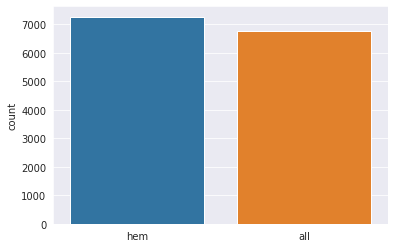

In [ ]:
show_data(train_data)

In [ ]:
indices = torch.randperm(len(train_data)).tolist()
n_val = math.floor(len(indices) * .30)
t_val = math.floor(n_val * .5)

t_val

2107

In [ ]:
train_ds = torch.utils.data.Subset(train_data, indices[:-n_val])
val_ds = torch.utils.data.Subset(train_data, indices[-n_val:-t_val])
test_ds= torch.utils.data.Subset(train_data, indices[-t_val:])
print(len(train_ds),len(val_ds),len(test_ds))

9834 2107 2107


In [ ]:
class ImageClassificationCollator:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor
 
    def __call__(self, batch):
        encodings = self.feature_extractor([x[0] for x in batch], return_tensors='pt')
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
        return encodings 

In [ ]:
#feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
#model = SwinForImageClassification.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k'
)
collator = ImageClassificationCollator(feature_extractor)
train_loader = DataLoader(train_ds, batch_size=8, collate_fn=collator, num_workers=4, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, collate_fn=collator, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=8, collate_fn=collator, num_workers=4)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
torch.save(train_loader,"/content/drive/MyDrive/GP DataSet/DataSets/C-NMC_Leukemia/"+ 'train_loader.pth')
torch.save(val_loader,"/content/drive/MyDrive/GP DataSet/DataSets/C-NMC_Leukemia/"+ 'val_loader.pth')
torch.save(test_loader,"/content/drive/MyDrive/GP DataSet/DataSets/C-NMC_Leukemia/"+ 'test_loader.pth')

In [ ]:
class Classifier(pl.LightningModule):

    def __init__(self, model, lr: float = 2e-5, **kwargs):
        super().__init__()
        self.save_hyperparameters('lr', *list(kwargs))
        self.model = model
        self.forward = self.model.forward
        self.val_acc = Accuracy()

    def training_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"train_loss", outputs.loss)
        return outputs.loss

    def validation_step(self, batch, batch_idx):
        outputs = self(**batch)
        self.log(f"val_loss", outputs.loss)
        acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
        self.log(f"val_acc", acc, prog_bar=True)
        return outputs.loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [ ]:
device='cuda' if torch.cuda.is_available() else 'cpu'
pl.seed_everything(42)
classifier = Classifier(model, lr=2e-5)
trainer = pl.Trainer(gpus=1, precision=16, max_epochs=6)
trainer.fit(classifier, train_loader,val_loader)

Global seed set to 42
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                      | Params
------------------------------------------------------
0 | model   | ViTForImageClassification | 85.8 M
1 | val_acc | Accuracy                  | 0     
------------------------------------------------------
85.8 M    Trainable params
0         Non-trainable params
85.8 M    Total params
171.600   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:245: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
val_batch = next(iter(val_loader))
outputs = model(**val_batch)
print('Preds: ', outputs.logits.sigmoid().argmax(1))
print('Labels:', val_batch['labels'])

Preds:  tensor([1, 1, 0, 1, 0, 1, 0, 1])
Labels: tensor([1, 1, 0, 1, 1, 1, 0, 1])


In [ ]:
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [ ]:
model_id = "vit_test_1_95" #@param {type:"string"}

description = """
Autogenerated by HuggingPics🤗🖼️

Create your own image classifier for **anything** by running [the demo on Google Colab](https://colab.research.google.com/github/nateraw/huggingpics/blob/main/HuggingPics.ipynb).

Report any issues with the demo at the [github repo](https://github.com/nateraw/huggingpics).
"""
task_name = "Image Classification"
task_type = 'image-classification'
metric_name = 'Accuracy'
metric_type = 'accuracy'
metric_value = trainer.callback_metrics['val_acc'].item()

# Delete model folder, as we (re)create it here.
if Path('./model').exists():
    shutil.rmtree('./model')

token = HfFolder().get_token()
if not token:
    raise RuntimeError("You must log in to push to hub! Run notebook_login() in the cell above.")

hf_username = HfApi().whoami()['name']
model_url = HfApi().create_repo(token=token, name=model_id, exist_ok=True)
model_repo = Repository("./model", clone_from=model_url, use_auth_token=token, git_email=f"{hf_username}@users.noreply.huggingface.co", git_user=hf_username)
model.save_pretrained(model_repo.local_dir)
feature_extractor.save_pretrained(model_repo.local_dir)

# Copy over tensorboard logs from lightning_logs/ into ./model/runs/
tensorboard_logs_path = next(Path(trainer.logger.log_dir).glob('events.out*'))
model_repo_logs_path = Path(model_repo.local_dir) / 'runs'
model_repo_logs_path.mkdir(exist_ok=True, parents=True)
shutil.copy(tensorboard_logs_path, model_repo_logs_path)

# Copy over a few example images
example_images_dir = Path(model_repo.local_dir) / 'images'
example_images_dir.mkdir(exist_ok=True, parents=True)
image_markdown_template = '''
#### {class_name}

![{class_name}](images/{example_image_path})
'''
example_images_markdown = ""



# Prepare README.md from information gathered above
readme_txt = f"""
---
tags:
- image-classification
- pytorch
- huggingpics
metrics:
- {metric_type}

model-index:
- name: {model_id}
  results:
  - task:
      name: {task_name}
      type: {task_type}
    metrics:
      - name: {metric_name}
        type: {metric_type}
        value: {metric_value}
---

# {model_id}

{description}

## Example Images

{example_images_markdown}

""".strip()

(Path(model_repo.local_dir) / 'README.md').write_text(readme_txt)

commit_url = model_repo.push_to_hub()

print("Check out your model at:")
print(f"https://huggingface.co/{hf_username}/{model_id}")

/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:82: FutureWarning: `name` and `organization` input arguments are deprecated and will be removed in v0.8. Pass `repo_id` instead.
  FutureWarning,
Cloning https://huggingface.co/25khattab/vit_test_1_95 into local empty directory.


Upload file pytorch_model.bin:   0%|          | 3.34k/327M [00:00<?, ?B/s]

Upload file runs/events.out.tfevents.1654823671.d314f0899d98.11569.0:  23%|##3       | 3.34k/14.5k [00:00<?, ?…

remote: Enforcing permissions...        
remote: Allowed refs: all        
To https://huggingface.co/25khattab/vit_test_1_95
   7f421b7..2a34af2  main -> main



Check out your model at:
https://huggingface.co/25khattab/vit_test_1_95
